In [29]:
import os
import glob

import pandas as pd
import numpy as np
import datetime

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr

from netCDF4 import Dataset

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #changed from Ernesto
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
import matplotlib.patheffects as PathEffects

### LOAD AND SET UP DATA (ARS)

In [30]:
#base path
base_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/'

#data paths
# depth_3m_path = 'depths_3m/equal_extent_data_downsize/{}/*.tif'
depth_3m_path = 'depths_3m/{}/*.tif'
# mask files
mask_3m_file = '/home/meganmason/Documents/projects/thesis/maps/map_layers/basin_ops/tuolumne/topo/basin_setup/topo.nc' #this is 3m, only TB, downloaded 8-8 with Micah
mask_50m_file = '/home/meganmason/Documents/projects/thesis/maps/map_layers/basin_ops/tuolumne/topo/topo_50m.nc' #first topo.nc downloaded, renamed to _50m.nc
# dem 
dem_3m_file = 'TB20140827_snow_free_dtm_vf_3p0m.tif'

#### load/set up (mm)

In [3]:
base_path = '/Users/megmason/Desktop/'
depth_3m_path = 'equal_extent_data_downsize/{}/*.tif'
# mask_3m_file = '/Users/megmason/Desktop/topo.nc'

In [31]:
# years and flight dates (3m)
years = list(range(2013,2019)) # 2013-2018

flist = []
for year in sorted(years):
    flist_yr = glob.glob(base_path + depth_3m_path.format(year))
    flist.extend(flist_yr) #.append adds list to lists (ie multiple lists), .extend tacks on to og list (ie one list) 
print('number of input files:', len(flist))
    
# ~~~~~~~~~~~~~~ASK MICAH FOR HELP - LIST COMPREHENSION  ~~~~~~~~~~~~  
# flist = ([glob.glob(flist_yr).extend for year in years])
# print(flist)
# flist = (glob.glob(base_path + depth_3m_path.format(year)) for year in years)
# print(flist)

number of input files: 51


In [32]:
# ~~~~~~~~~~~~~~~function for DATETIME
def flight_date(f):
#     print(f)
    dt_str = f.split("/")[-1] #splits on / and saves the last one
    dt_str = "".join([c for c in dt_str if c.isnumeric()]) #grabs numeric values
    dt = pd.to_datetime(dt_str[:8]) #convert to datetime, grabs digits for dates only
#     print('flight date:',dt.date())
#         dates.append(dt.date()) #.date to exclude time (00:00:00)
    
    return dt.date() #pd.to_datetime(dt.date)
#     return dt
# datelist = [flight_date(f) for f in sorted(flist)] 
#print(datelist[0].strftime('%Y-%m-%d'))

#### Mask (from topo.nc)

odict_keys(['y', 'x', 'veg_height', 'veg_tau', 'veg_k', 'veg_type', 'dem', 'mask', 'projection'])
mask shape: (17002, 17569) 
mask value to use: 1 
# of pixels in mask: 131291738


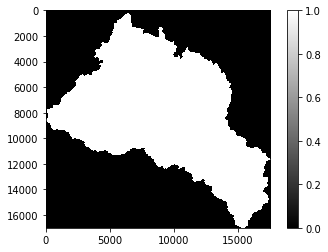

In [33]:
#mask checking (3m)
ds = Dataset(mask_3m_file) #using 'from netCDF4 import Dataset'
print(ds.variables.keys())
mask = ds.variables['mask'] #grab tum mask variable, use ds.variables.keys() to list all possible variables
n_tuolumne_mask = mask[mask == 1].size #Ernesto added ( this can be used to divide in hist df to get percentage)
print('mask shape:', mask.shape, 
      '\nmask value to use:', np.max(mask), 
      '\n# of pixels in mask:', np.sum(mask))
plt.imshow(mask, cmap='gray')
plt.colorbar()

#### font sizes

In [34]:
fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20

### ANALYSIS..testing

In [25]:
#~~~~~~ FUNCTIONS ~~~~~~~~~~~~~~~~~~~~

def describe_lidar_data(depth_array, mask_array = None, mask_value = None):
    
    '''calculates the mean of a lidar flight -- will add more summary statistics'''
    
    if mask_array is None:
        
        sn_mean = np.nanmean(depth_array[depth_array > 0])
        sn_std  = np.nanstd(depth_array[depth_array > 0])
        sn_min  = np.nanmin(depth_array[depth_array > 0])
        sn_max  = np.nanmax(depth_array[depth_array > 0])
        column = [sn_mean, sn_std, sn_min, sn_max]
        return column
    
    else: 
        sn_mean = np.nanmean(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        sn_std  = np.nanstd(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        sn_min  = np.nanmin(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        sn_max  = np.nanmax(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        column = [sn_mean, sn_std, sn_min, sn_max]
        return column 
        #return {"mean":sn_mean, "std": sn_std, "min": sn_min, "max": sn_max}
        

In [35]:
# ~~~~~ CALL FUNCTIONS ~~~~~~~~~~~~ (describe lidar data)

df = pd.DataFrame()

for f in sorted(flist):
#     print('file:',f)
    fDate = flight_date(f)
    d = io.imread(f) #is numpy array 
#     print('type:', type(d), 'shape:', d.shape)
    column = describe_lidar_data(d/1000, mask_array = mask, mask_value=np.max(mask))
#     column = describe_lidar_data(d) #, mask_array = None, mask_value=None)
    df[fDate] = column
df = df.transpose()
df.columns = ['mean','std','min','max']
df

ValueError: operands could not be broadcast together with shapes (17002,17569) (16780,17699) 

In [28]:
'''save to csv'''
# ars path
# export_csv = df.to_csv('/home/meganmason/Documents/projects/thesis/figures/tables/summarystats_df_raw.csv', index = True, header=True) #ind=T stores row names

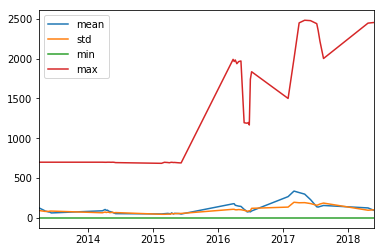

In [14]:
df.plot() #quick check of dataframe

In [15]:
# Histogram Function

def histogram_df(depth_array, binx, mask_array = None, mask_value = None):
    
    ''' histogram dataframe
            input:
                depth_array: numpy array of snow depths (cm)
                binx: np array of start, stop, stepby
                mask_array: (optional) mask of area for depth calculation
                mask_value: (optional) value of the mask to calculate over
                NOTE: depth_array and mask must have save extent size (x min/max and y min/max -->gdalwarp -te <>, -tr <>)
                
            return:
                hist: tuple (frequency[0], bin_edge[1])
                num_pix_zero: number of pixels that are zero within the mask'''
    
    if mask_array is None:
        hist = np.histogram(depth_array[depth_array>0], binx)
        num_pix_zero = depth_array[depth_array == 0].size
    
    else: 
        hist = np.histogram(depth_array[(mask_array == mask_value) & (depth_array > 0)], binx)
        num_pix_zero = depth_array[(mask_array == mask_value) & (depth_array == 0)].size
        
    return hist, num_pix_zero


In [28]:
# # Histogram Function (normalized)

# def histogram_df(depth_array, binx, norm=False, mask_array = None, mask_value = None):
    
#     ''' histogram dataframe'''
#     if mask_array is None:
#         hist = np.histogram(depth_array[depth_array>0], binx)
#         return hist
    
#     if norm is True:
#         d_norm = depth_array/np.mean(depth_array[depth_array>0])
#         hist_norm = np.histogram(d_norm[(mask_array == mask_value) & (depth_array > 0)], binx)
#         return hist_norm
    
#     else: 
#         hist = np.histogram(depth_array[(mask_array == mask_value) & (depth_array > 0)], binx)
#         return hist

In [16]:
#call histogram function

df_h = pd.DataFrame()
num_zeros = []
binx = np.arange(0,2500,2) #0-30m, steps by 30cm (2017/18 maxes out at 24m....so went above to compute every pixel)

for f in sorted(flist):
    fDate = flight_date(f)
    d = io.imread(f)
    [hist, num_pix_zero] = histogram_df(d, binx) #mm since I dont have mask yet
#     [hist, num_pix_zero] = histogram_df(d, binx, mask_array = mask, mask_value=np.max(mask))
    df_h[fDate]=hist[0] #each column is a flight date
    num_zeros.append(num_pix_zero)
    
df_h = df_h.set_index(hist[1][:-1])#index first col as left bin edges
df_h.loc['zeros'] = num_zeros
# df_h

In [18]:
'''save to csv!'''

# ars path
export_csv = df_h.to_csv('/home/meganmason/Documents/projects/thesis/figures/tables/histogram_df_2cm.csv', index = True, header=True) #ind=T stores row names
# mm path
# export_csv = df_h.to_csv('/Users/megmason/Desktop/outputs/histogram_df.csv', index = True, header=True)

In [17]:
# Values Flattened Function (options: mask/no mask, zeros/no zeros)

def values_flat(depth_array, zeros = False, mask_array = None, mask_value = None):
    
    '''snow depth values flattened'''
    if mask_array is None:
        d = depth_array
        d_flat = d.flatten()
        return d_flat
    
    if zeros is True: #include zeros in flattened array (wouldn't want this for SCA)
        pass
        d = depth_array[(mask_array == mask_value)] #zeros are still included 
        return d
    
    else: #do stats without zeros
        d = depth_array[(mask_array == mask_value) & (depth_array > 0)] #zeros NOT included
        return d

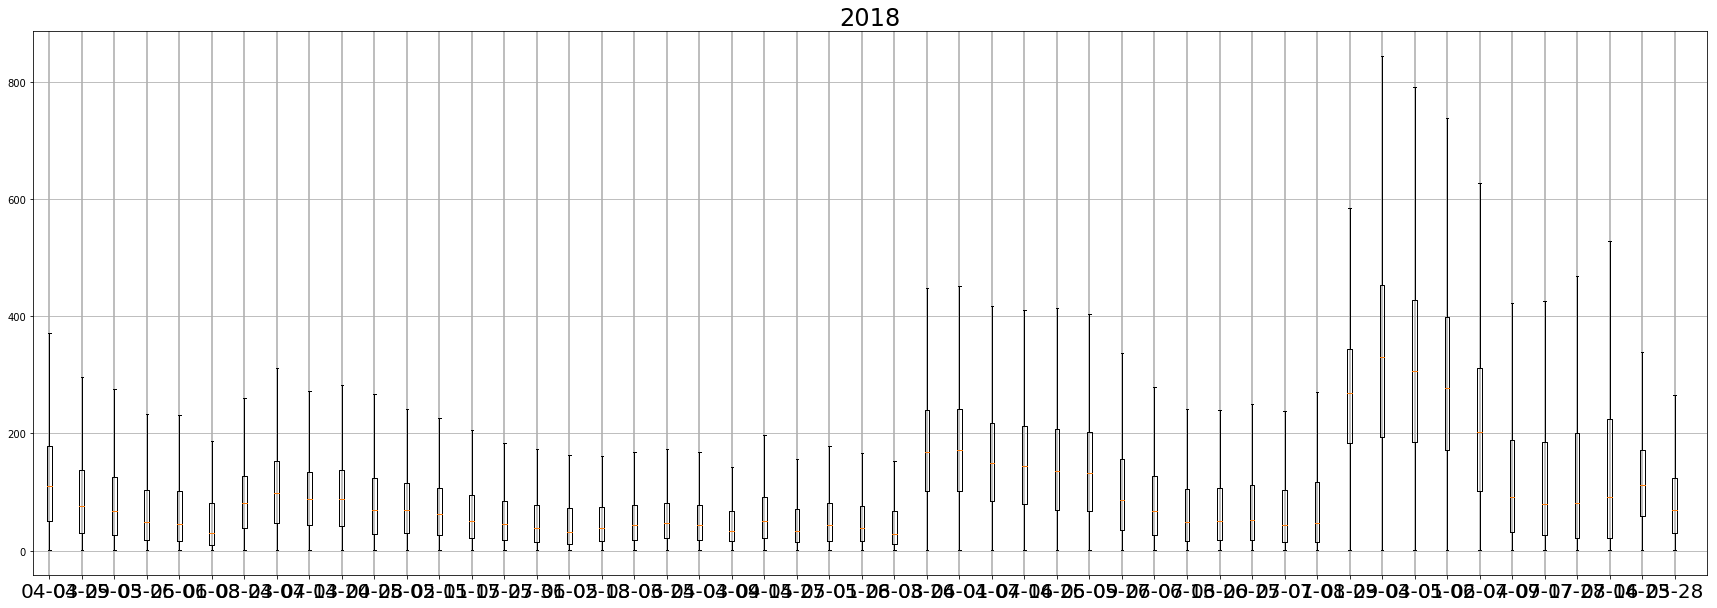

In [18]:
fDate_list=[]
fig = plt.figure(figsize=(30,10))
axs = plt.gca()

for i,f in enumerate(sorted(flist)): #[:3]):
#     print(i)
    fDate = flight_date(f) #class datetime.date type
    fDate_list.append(fDate.strftime('%m-%d'))
#     print('fDate is:', fDate, 'type is:', type(fDate))
    d = io.imread(f)
    v = values_flat(d, zeros=False, mask_array = mask, mask_value=np.max(mask)) #zeros=False is default...
#     print(fDate.strftime('%Y'))#%m%d'))
    axs.boxplot(v, sym='', positions=[i])#, labels=[fDate.strftime('%Y%m%d')]) 
    
axs.set_xlim((-.5,len(flist))) #doesn't cut off left side, and is as long as # of files
axs.set_xticks(range(i+1))
axs.set_xticklabels(fDate_list, fontsize = fs_axes)
# axs.set_xticklabels(fDate_list)
axs.set_title(fDate.strftime('%Y'), fontsize=fs_titles)

for ax in fig.get_axes():

    ax.grid(which='major')
#     ax.minorticks_on()
#     ax.grid(which='minor', ls='--')
    ax.grid(which='major', axis='x', ls='-', lw=1.5, c='darkGrey')

plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/boxplot_{}.png'.format(fDate.strftime('%Y')), dpi=300)   
plt.show()

number of input files: 6
number of input files: 11
number of input files: 10
number of input files: 13
number of input files: 9
number of input files: 2
number of input files: 6
number of input files: 11
number of input files: 10


KeyboardInterrupt: 

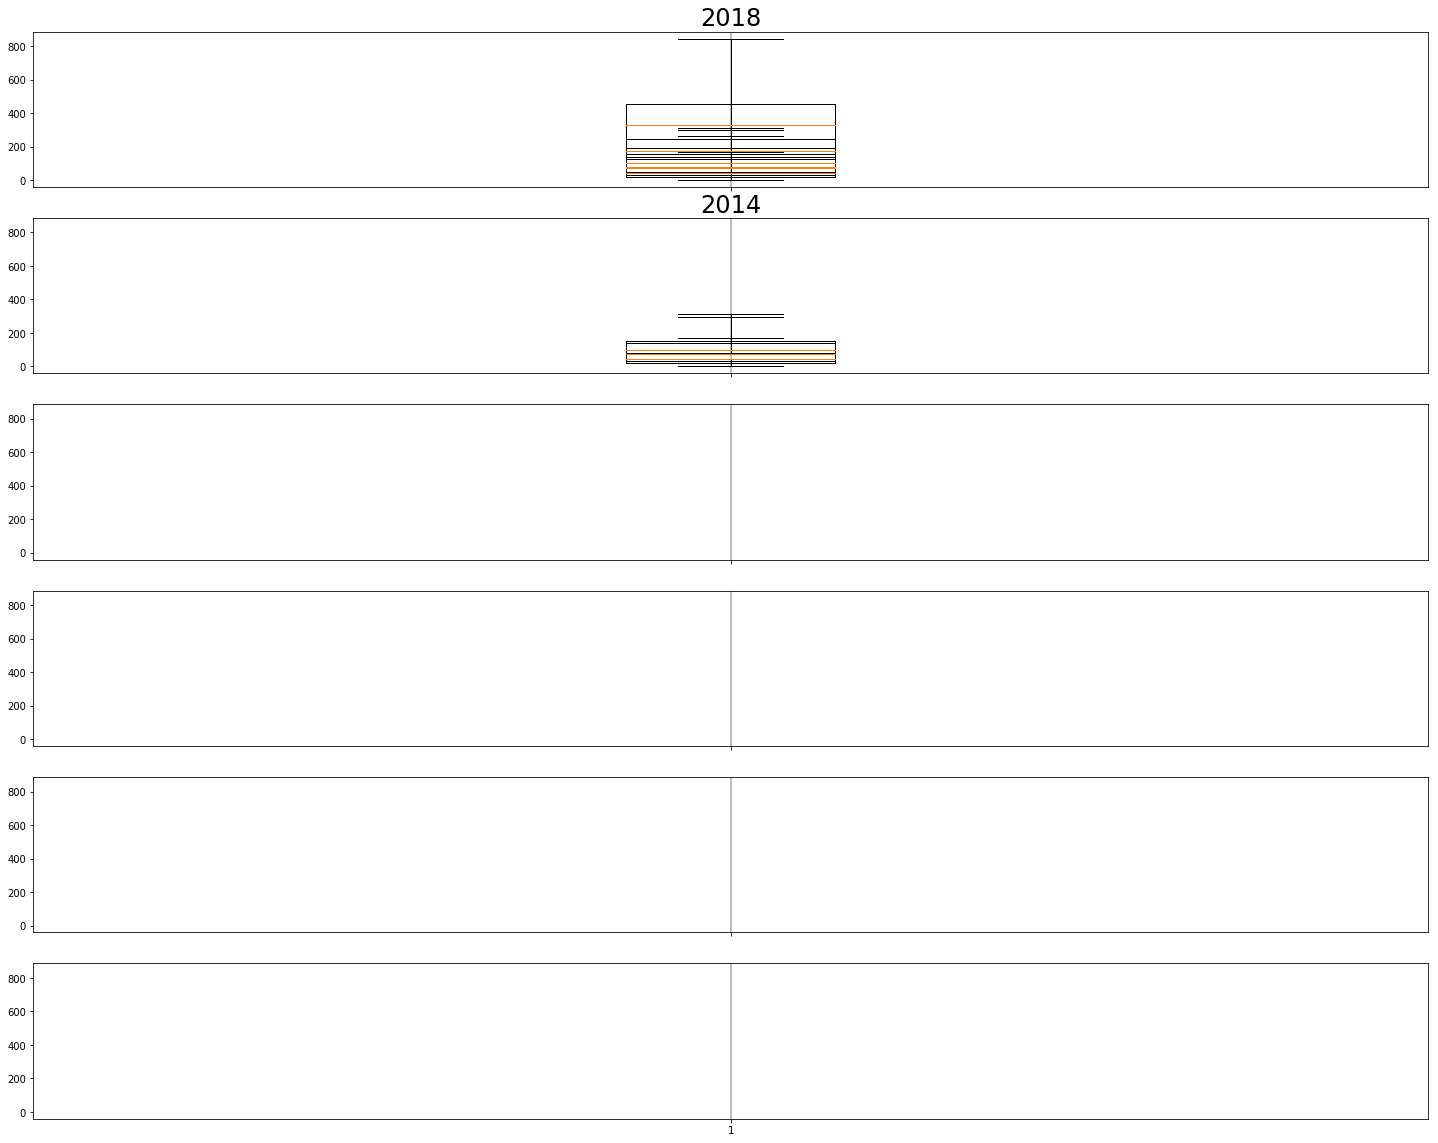

In [23]:
#multiple plots

fDate_list=[]
fig,axes = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(25,20))
# ax = plt.gca()


years = list(range(2013,2019)) # 2013-2018


for axs in axes.flat:
    for year in sorted(years):
        flist = []
        flist_yr = glob.glob(base_path + depth_3m_path.format(year))
        flist.extend(flist_yr) #.append adds list to lists (ie multiple lists), .extend tacks on to og list (ie one list) 
        print('number of input files:', len(flist))



        for i,f in enumerate(sorted(flist)): #[:3]):
            fDate = flight_date(f) #class datetime.date type
            fDate_list.append(fDate.strftime('%m-%d'))
        #     print('fDate is:', fDate, 'type is:', type(fDate))
            d = io.imread(f)
            v = values_flat(d, zeros=False, mask_array = mask, mask_value=np.max(mask)) #zeros=False is default...
        #     print(fDate.strftime('%Y'))#%m%d'))
            axs.boxplot(v, sym='', positions=[i])#, labels=[fDate.strftime('%Y%m%d')]) 

        axs.set_xlim((-.5,len(flist))) #doesn't cut off left side, and is as long as # of files
        axs.set_xticks(range(i+1))
        axs.set_xticklabels(fDate_list, fontsize = fs_axes)
        # axs.set_xticklabels(fDate_list)
        axs.set_title(fDate.strftime('%Y'), fontsize=fs_titles)

        for ax in fig.get_axes():

            ax.grid(which='major')
        #     ax.minorticks_on()
        #     ax.grid(which='minor', ls='--')
            ax.grid(which='major', axis='x', ls='-', lw=1.5, c='darkGrey')

# plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/boxplot_{}.png'.format(fDate.strftime('%Y')), dpi=300)   
plt.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
print(fDate_list)

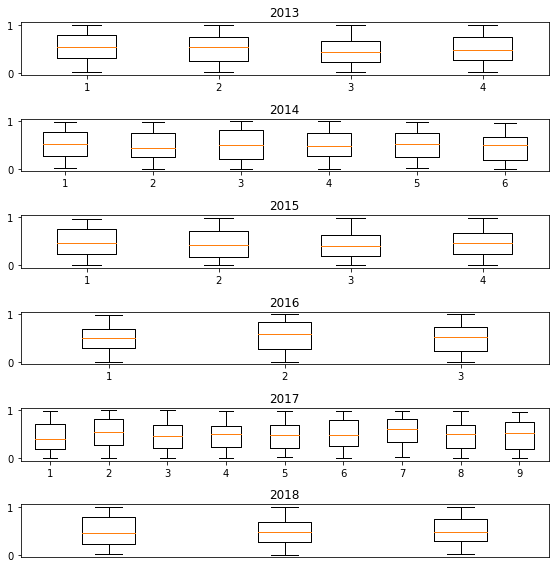

In [14]:
# template multiple plots (boxplots)

import random
d_list = []
years = range(2013,2019) # 2013-2018 #NOT A LIST and it works....vs list(range(2013,2019))
z=0

# plt.figure(figsize = (50, 20))
fig,axs=plt.subplots(6,1,figsize = (8,8))


for ax in axs.flat:
    date=pd.to_datetime("10-01-2013")
    d_list.append(date)
    arr=np.random.rand(100,np.random.randint(3,10))
    bx = ax.boxplot(arr)

    ax.set_title('{}'.format(years[z]))
    
    z+=1

    
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)



plt.tight_layout()
plt.show()

In [ ]:
# df_values = pd.DataFrame()
# lst_values = []
    

    
    #     print(v.shape)
#     print(v)
    
# #     df_values[fDate]=v
#     lst_values.append(v)
# # plt.boxplot(df_values)
    
#     hist = histogram_df(d, binx, mask_array = mask, mask_value=np.max(mask))
# #     hist = histogram_df(d, binx) 
# #     print(hist[0])
#     df_h[fDate]=hist[0]

In [ ]:
for f in sorted(flist):
    print(f)

In [ ]:
# Boxplot Function

def boxplot(depth_array,mask_array = None, mask_value = None):
    
    ''' boxplot by dates'''
    if mask_array is None:
        pass
#         hist = np.histogram(depth_array[depth_array>0], binx)
#         return hist
    else: 
        bxplt = plt.boxplot(depth_array[(mask_array == mask_value) & (depth_array > 0)])
        return bxplt

In [ ]:
# call boxplot function

for f in sorted(flist):
    print(f)
    fDate = flight_date(f)
    d = io.imread(f)
    bxplt=boxplot(d, mask_array = mask, mask_value=np.max(mask))
    plt.figure(figsize=(15,5))
    df_h[column].plot.bar(width=0.85, align='edge')
    plt.title(str(column), fontsize=fs_titles)
    plt.xlabel('snow depth [cm]', fontsize=fs_axes); plt.ylabel('probability', fontsize=fs_axes)

In [ ]:
#example dataframe..
df = pd.DataFrame()
df['lidar flight'] = [ 2013 , 2014 , 2015] 
df['mean'] = ['5','5','5']
df['std'] = ['5','5','5']
df['min'] = ['5','5','5']
df['max'] = ['5','5','5']
df['#pixels'] = ['5','5','5']
df.set_index('lidar flight', inplace=True)
df

In [ ]:
for f in sorted(flist):
    d = io.imread(f) #is numpy array 
    print(f, d.shape)